In [2]:
# TODO: include values only in noon report data
# TODO: inspect that datetime conversion happened correctly (one of each data point, maybe additional checks)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os

In [4]:
notebook_dir = os.getcwd()
data_dir = os.path.dirname(os.path.dirname(notebook_dir))
appended_dir = os.path.join(data_dir, 'appended')
data_path = os.path.join(appended_dir, 'excl_noon_reports.csv')

df = pd.read_csv(data_path, parse_dates=['utc_timestamp'])

df['utc_timestamp'] = pd.to_datetime(df['utc_timestamp'], format='ISO8601')

In [15]:
qid_mappings = pd.read_csv(os.path.join(data_dir, 'metadata', 'Metrics registration.csv'))
qid_mapping_dict = dict(zip(qid_mappings['quantity_name'], qid_mappings['qid_mapping']))
qid_mapping_dict

{'Vessel Hull Aft Draft': '3::0::1::0_1::1::0::2::0_11::0::2::0_8',
 'Vessel Hull Fore Draft': '3::0::1::0_1::1::0::2::0_11::0::1::0_8',
 'Main Engine Rotational Speed': '3::0::1::0_1::2::0::8::0_1::0::6::0_8',
 'Vessel Hull MidP Draft': '3::0::1::0_1::1::0::2::0_11::0::3::0_8',
 'Vessel Hull MidS Draft': '3::0::1::0_1::1::0::2::0_11::0::4::0_8',
 'Vessel External Conditions Wind Relative Speed': '2::0::1::0_1::1::0::7::0_1::0::4::22_8',
 'Vessel External Conditions Wind Relative Angle': '2::0::1::0_1::1::0::7::0_2::0::15::22_8',
 'Vessel Hull Relative To Transducer Water Depth': '2::0::4::0_1::1::0::2::0_37::0::2::0_8',
 'Vessel Hull Over Ground Speed': '2::0::6::1_1::1::0::2::0_1::0::1::0_8',
 'Vessel Hull Heading Turn Rate': '2::0::5::0_1::1::0::2::0_6::0::1::0_8',
 'Vessel Hull Heading True Angle': '2::0::5::0_1::1::0::2::0_2::0::8::21_8',
 'Main Engine Turbocharger Rotational Speed': '1::0::15::0_1::2::0::3::0_1::0::6::0_8',
 'Vessel Hull Through Water Longitudinal Speed': '2::0::

In [5]:
df.shape

(41079968, 6)

In [6]:
df.head()

,utc_timestamp,qid_mapping,value,quantity_name,source_name,unit
0,2024-01-01 00:00:00+00:00,4::0::8::0_1::1::0::7::0_56::0::3::0_8,-0.4000,Vessel External Conditions Eastward Sea Water ...,Provider S,m/s
1,2024-01-01 00:00:00+00:00,4::0::4::0_1::1::0::7::0_56::0::4::0_8,0.0000,Vessel External Conditions Northward Sea Water...,Provider MB,m/s
2,2024-01-01 00:00:00+00:00,4::0::4::0_1::1::0::7::0_45::0::1::0_8,2.7000,Vessel External Conditions Wave Significant He...,Provider MB,m
3,2024-01-01 00:00:00+00:00,4::0::8::0_1::1::0::7::0_56::0::5::0_8,0.5391,Vessel External Conditions Eastward Wind Velocity,Provider S,m/s
4,2024-01-01 00:00:00+00:00,4::0::4::0_1::1::0::7::0_2::0::15::21_8,79.0000,Vessel External Conditions Wind True Angle,Provider MB,degrees


In [7]:
df.tail()

,utc_timestamp,qid_mapping,value,quantity_name,source_name,unit
41079963,2024-12-31 23:59:45.021000+00:00,3::0::1::0_1::2::0::8::0_1::0::6::0_8,0.0,Main Engine Rotational Speed,Control Alarm Monitoring System,rpm
41079964,2024-12-31 23:59:45.021000+00:00,3::0::1::0_1::1::0::2::0_11::0::3::0_8,0.0,Vessel Hull MidP Draft,Control Alarm Monitoring System,m
41079965,2024-12-31 23:59:45.021000+00:00,3::0::1::0_1::1::0::2::0_11::0::1::0_8,0.0,Vessel Hull Fore Draft,Control Alarm Monitoring System,m
41079966,2024-12-31 23:59:45.021000+00:00,3::0::1::0_1::1::0::2::0_11::0::4::0_8,0.0,Vessel Hull MidS Draft,Control Alarm Monitoring System,m
41079967,2024-12-31 23:59:45.021000+00:00,3::0::1::0_1::1::0::2::0_11::0::2::0_8,0.0,Vessel Hull Aft Draft,Control Alarm Monitoring System,m


In [8]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 41079968 entries, 0 to 41079967
Data columns (total 6 columns):
 #   Column         Dtype              
---  ------         -----              
 0   utc_timestamp  datetime64[us, UTC]
 1   qid_mapping    str                
 2   value          float64            
 3   quantity_name  str                
 4   source_name    str                
 5   unit           str                
dtypes: datetime64[us, UTC](1), float64(1), str(4)
memory usage: 1.8 GB


In [9]:
df.describe()

,value
count,4.107997e+07
mean,2.795997e+08
std,1.250238e+09
min,-2.475704e+04
25%,0.000000e+00
50%,1.210000e+01
75%,3.040000e+02
max,6.776511e+09


In [27]:
# check if all variables have data for all days in the whole dataset
def check_monthly_distribution(df, var_qid, var_name):
    days = df['utc_timestamp'].dt.day.unique()
    expected_days = 365
    
    print(f"Variable Name: {var_name}")
    print(f"Expected days: {expected_days}")
    print(f"Actual days: {sorted(days)}")
    
    counts_per_day = df[df['qid_mapping'] == var_qid].groupby(df['utc_timestamp'].dt.dayofyear).size()
    plt.figure(figsize=(10, 5))
    counts_per_day.plot(kind='bar', width=1.0)
    plt.title(f'Data Points per Day for Variable Name {var_name}')
    plt.xlabel('Day of Month')
    plt.ylabel('Number of Data Points')
    plt.show()
    

Variable Name: Vessel Hull Aft Draft
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


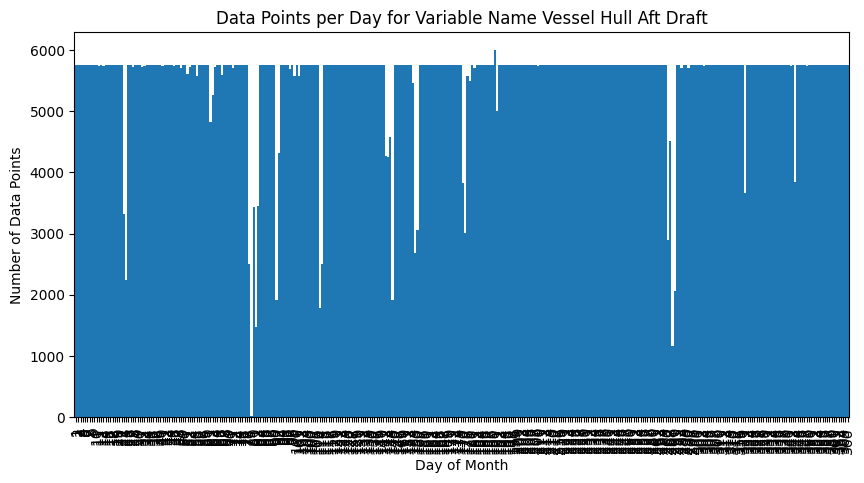

Variable Name: Vessel Hull Fore Draft
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


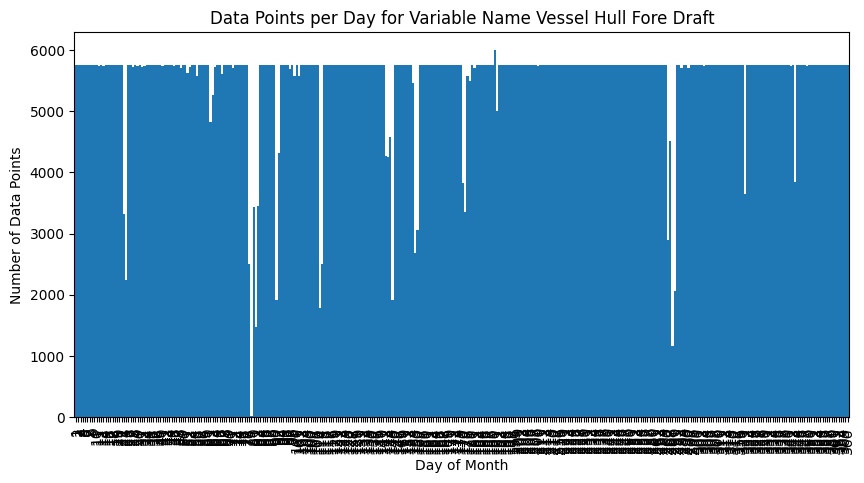

Variable Name: Main Engine Rotational Speed
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


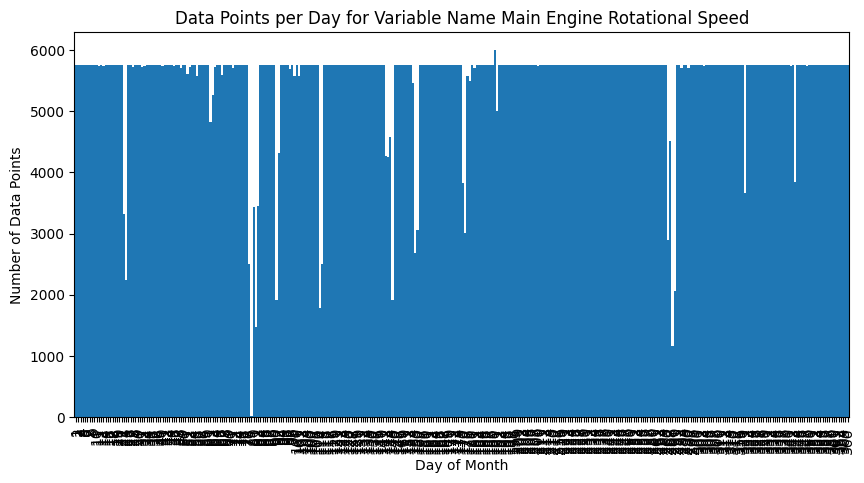

Variable Name: Vessel Hull MidP Draft
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


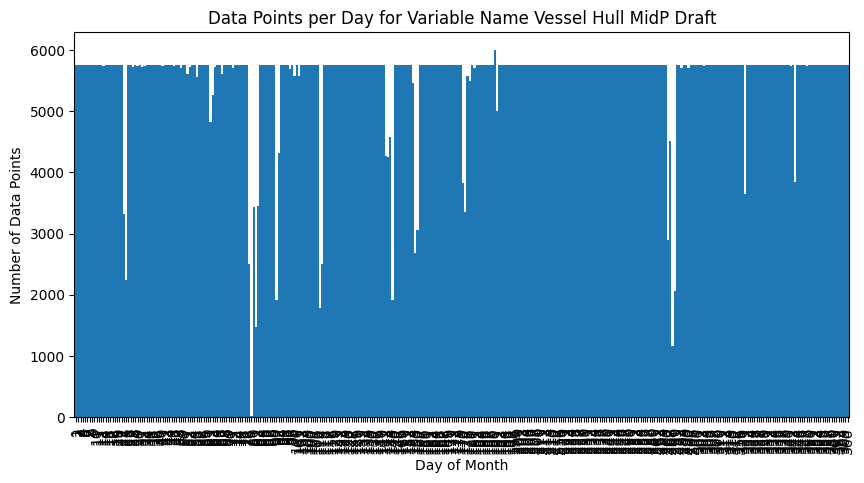

Variable Name: Vessel Hull MidS Draft
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


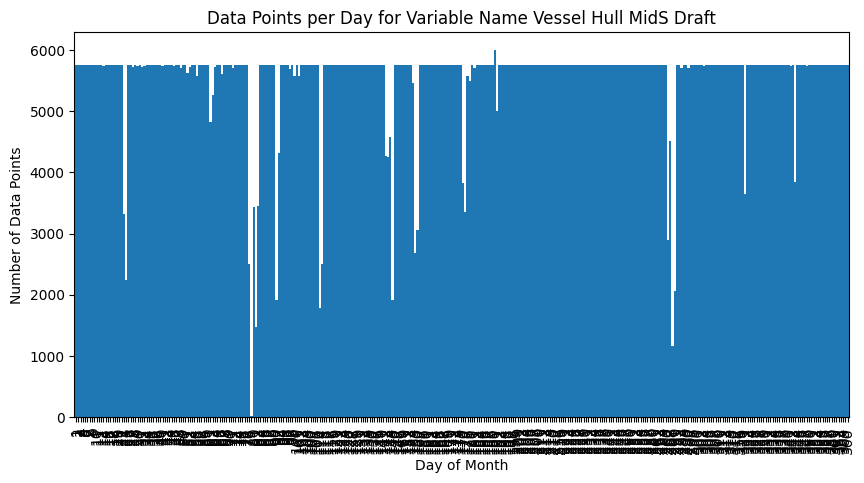

Variable Name: Vessel External Conditions Wind Relative Speed
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


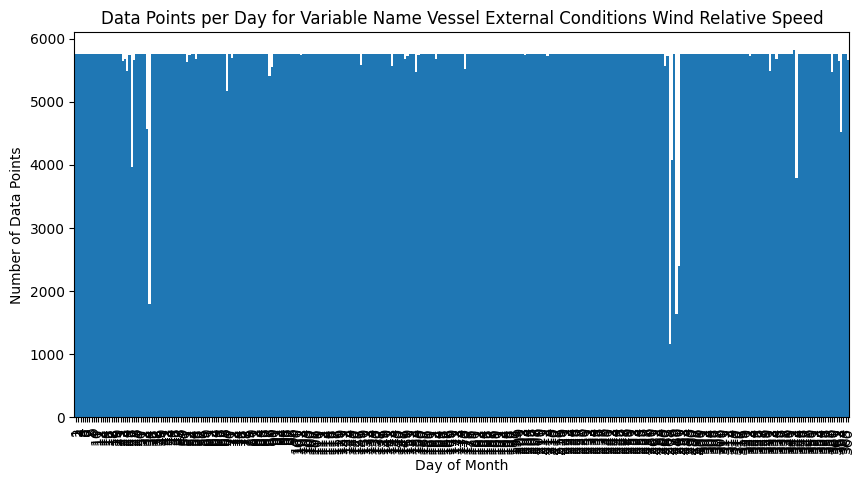

Variable Name: Vessel External Conditions Wind Relative Angle
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


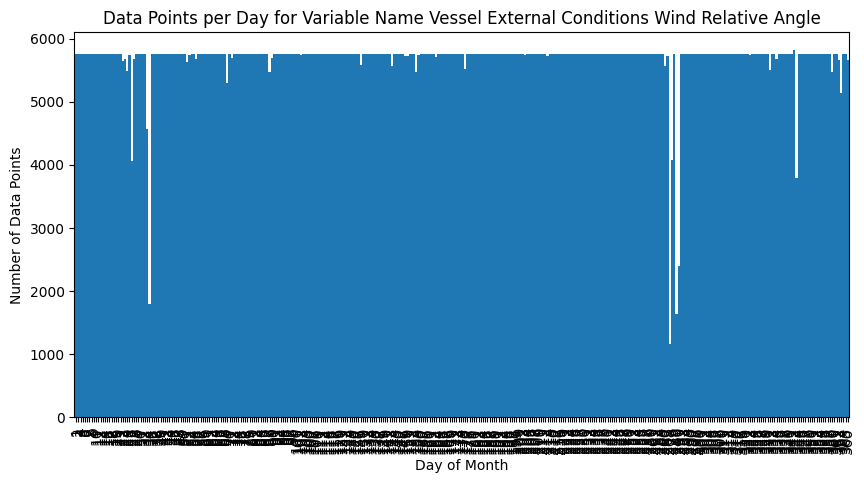

Variable Name: Vessel Hull Relative To Transducer Water Depth
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


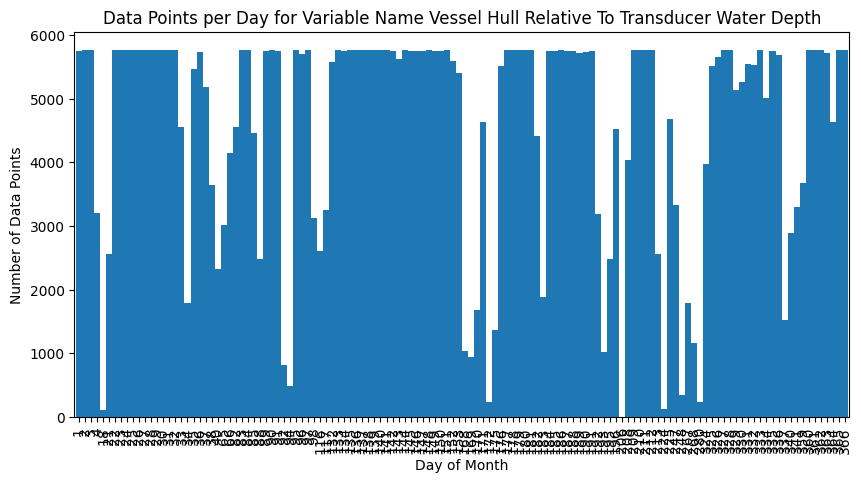

Variable Name: Vessel Hull Over Ground Speed
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


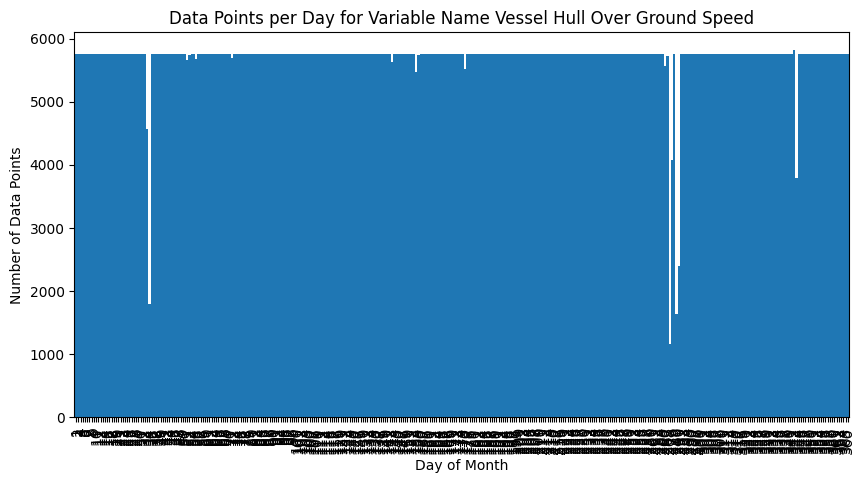

Variable Name: Vessel Hull Heading Turn Rate
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


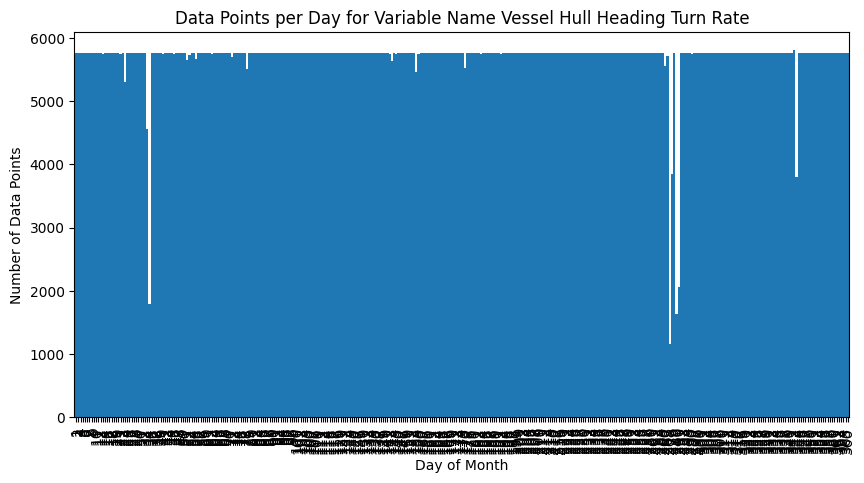

Variable Name: Vessel Hull Heading True Angle
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


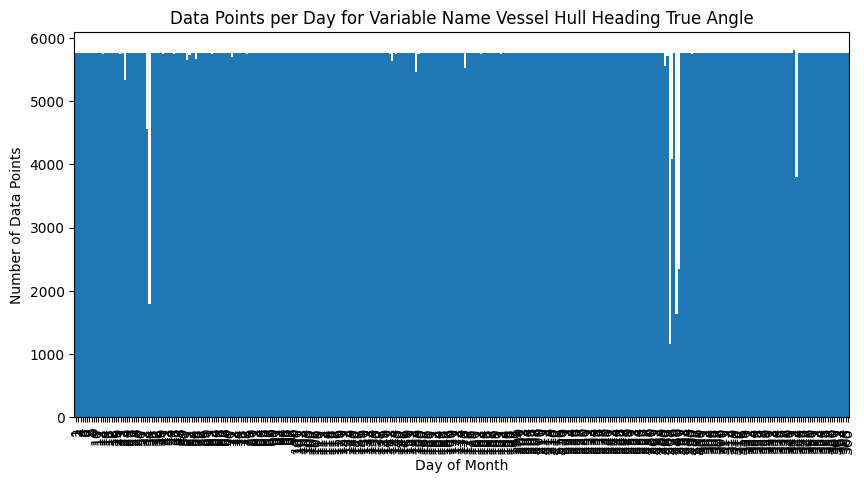

Variable Name: Main Engine Turbocharger Rotational Speed
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


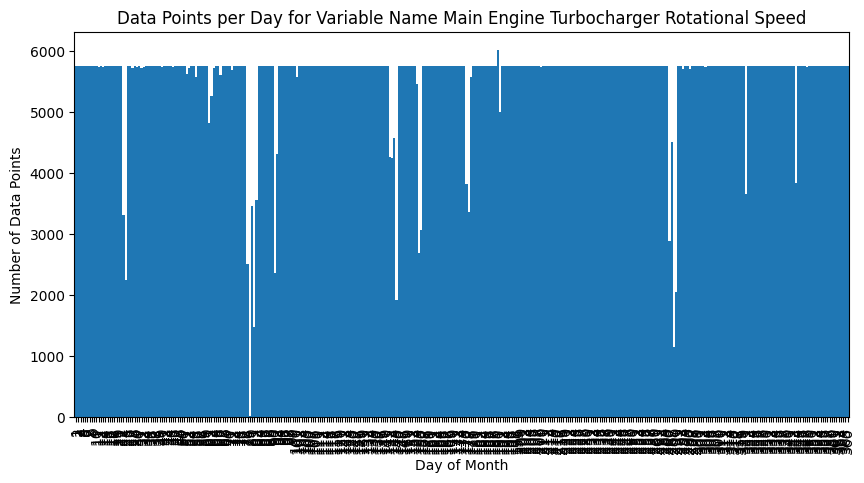

Variable Name: Vessel Hull Through Water Longitudinal Speed
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


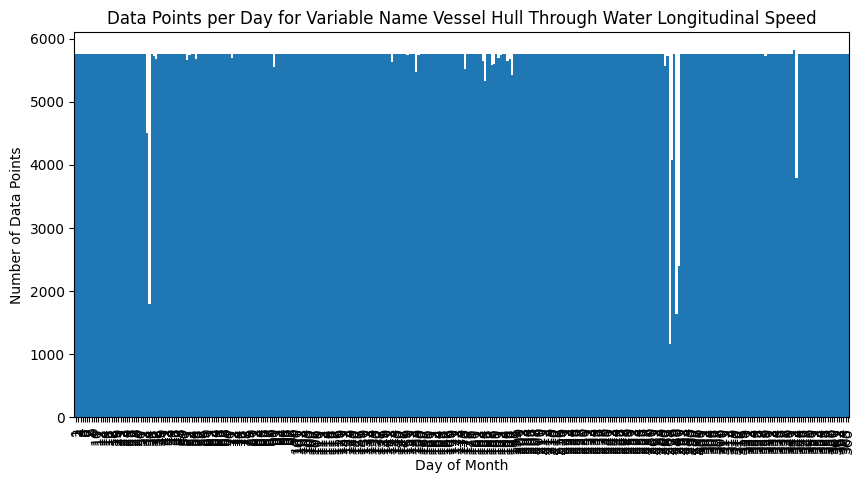

Variable Name: Main Engine Fuel Oil Inlet Mass Flow
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


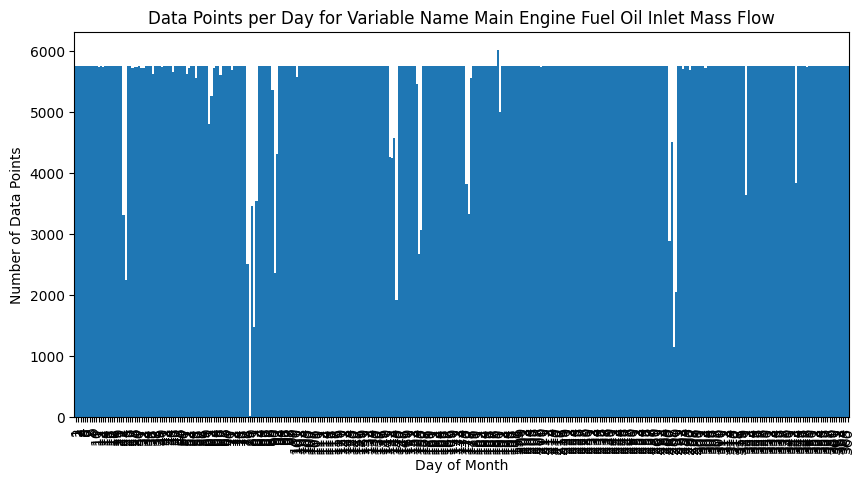

Variable Name: Vessel Propeller Shaft Mechanical Power
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


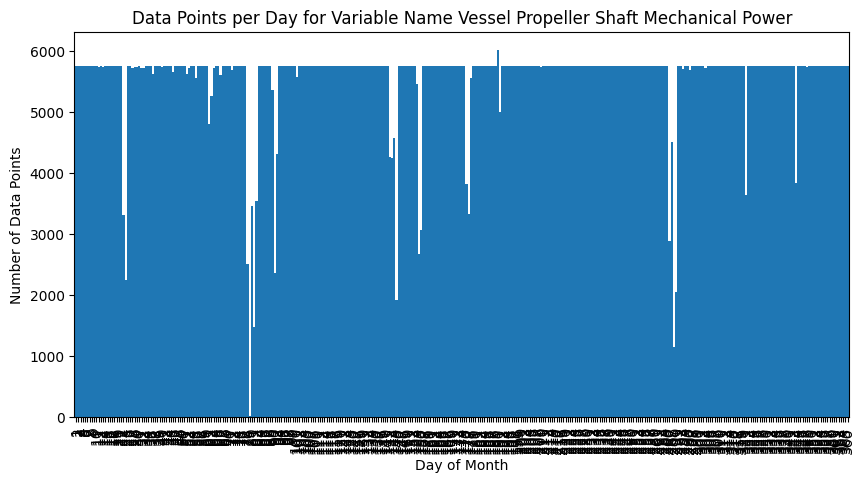

Variable Name: Vessel Propeller Shaft Rotational Speed
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


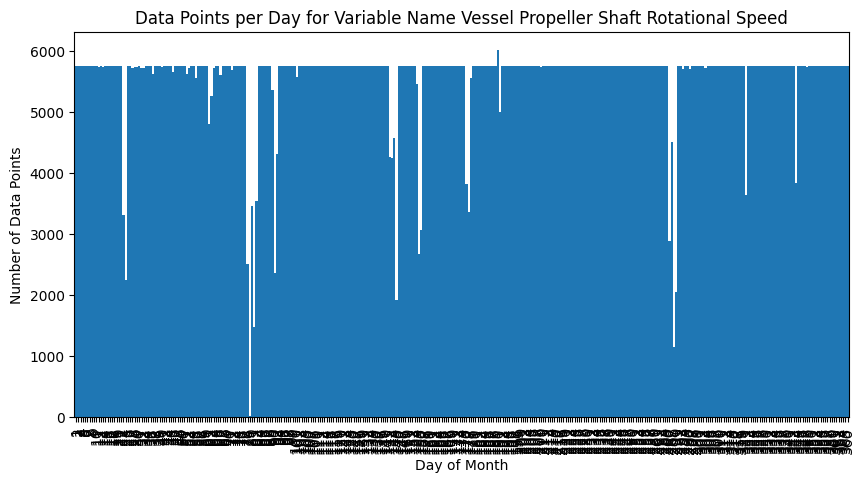

Variable Name: Vessel Propeller Shaft Torque
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


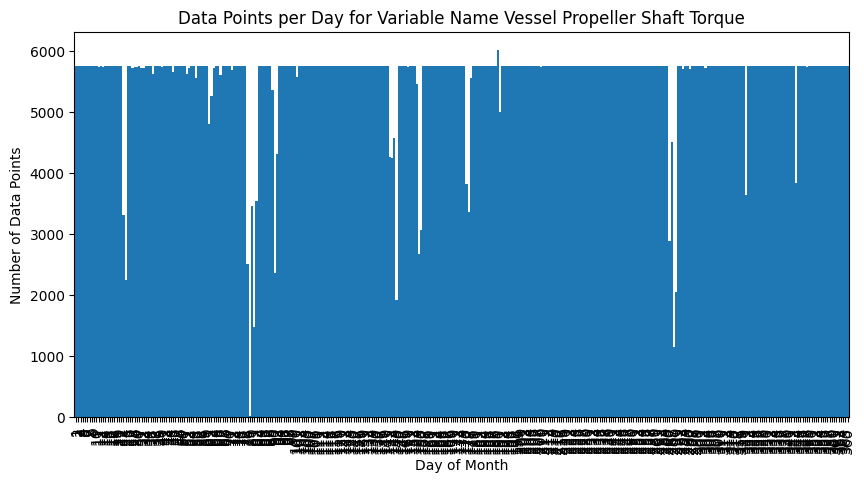

Variable Name: Vessel Propeller Shaft Thrust Force
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


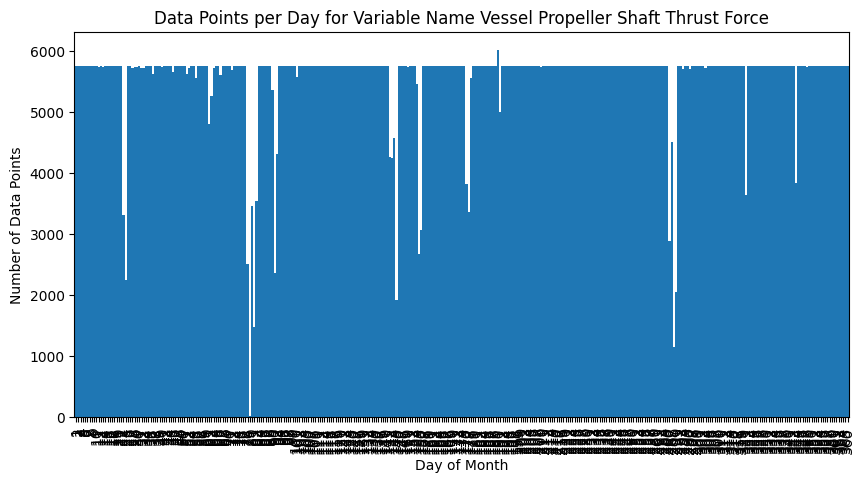

Variable Name: Vessel Propeller Shaft Mechanical Energy
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


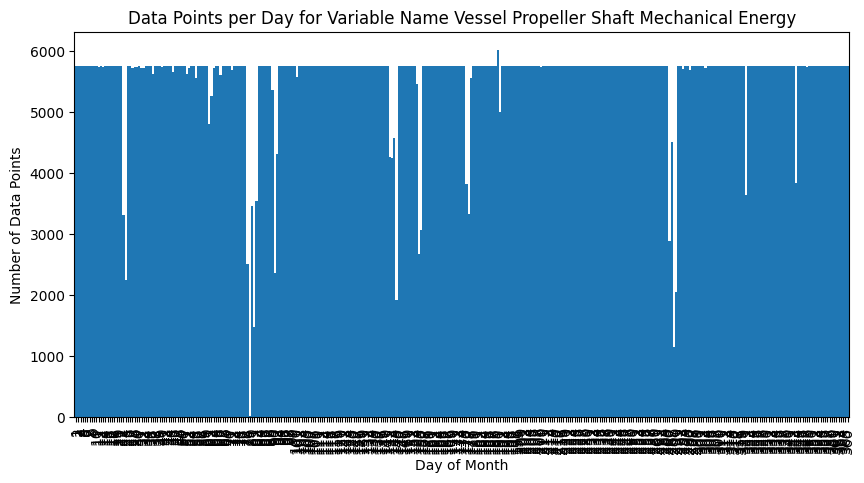

Variable Name: Vessel Propeller Shaft Revolutions (cumulative)
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


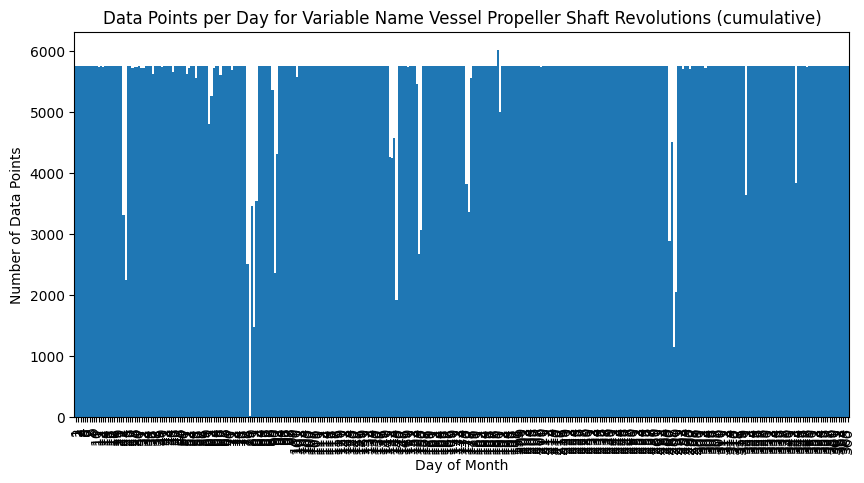

Variable Name: Vessel External Conditions Wave Significant Height
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


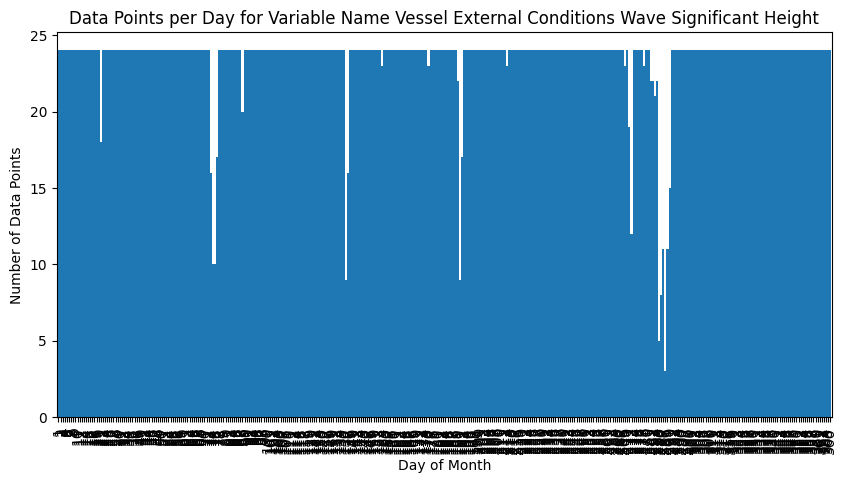

Variable Name: Vessel External Conditions Wind True Angle
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


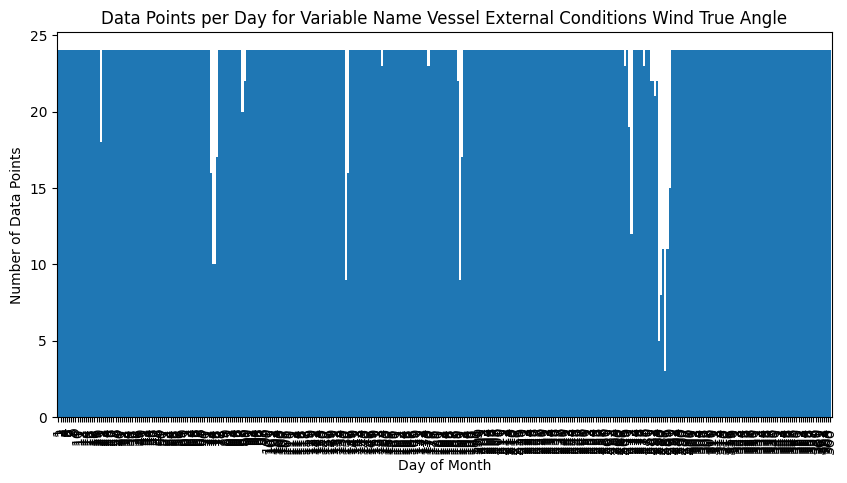

Variable Name: Vessel External Conditions Swell Significant Height
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


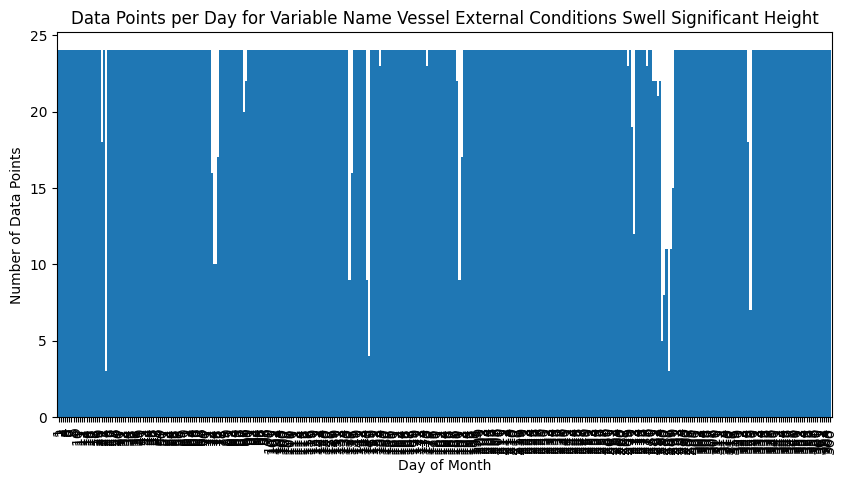

Variable Name: Vessel External Conditions Wind True Speed
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


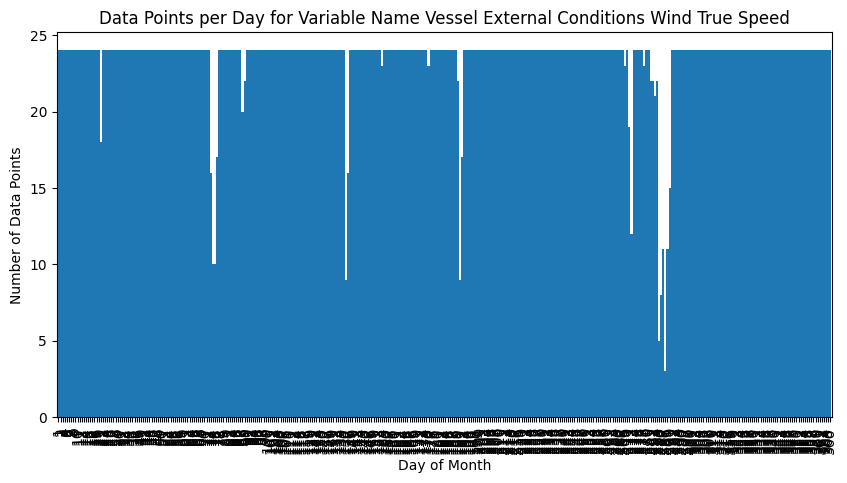

Variable Name: Vessel External Conditions Wave True Angle
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


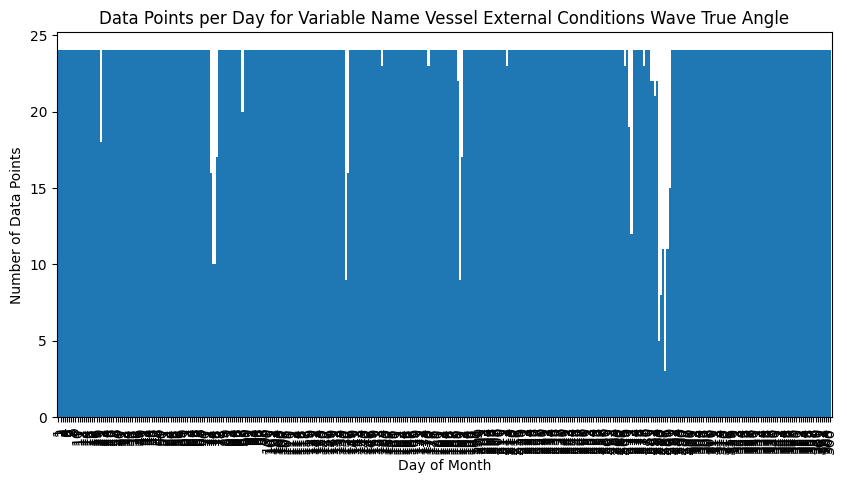

Variable Name: Vessel External Conditions Wave Period
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


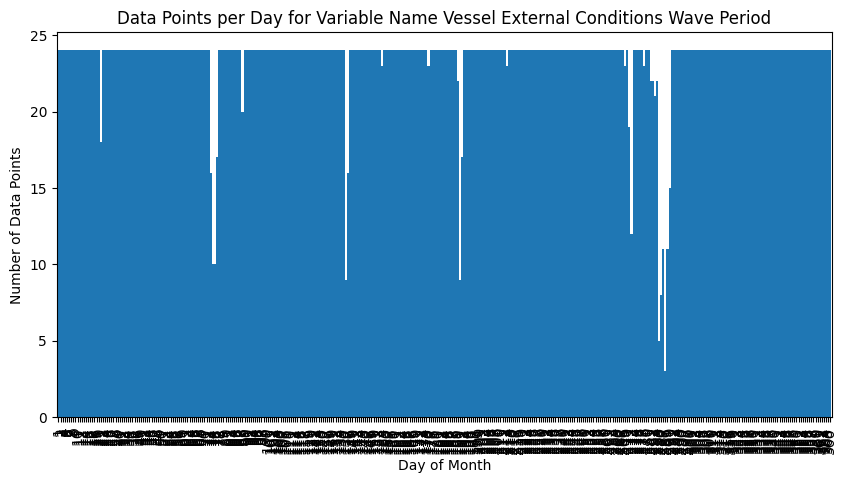

Variable Name: Vessel External Conditions Sea Water Temperature
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


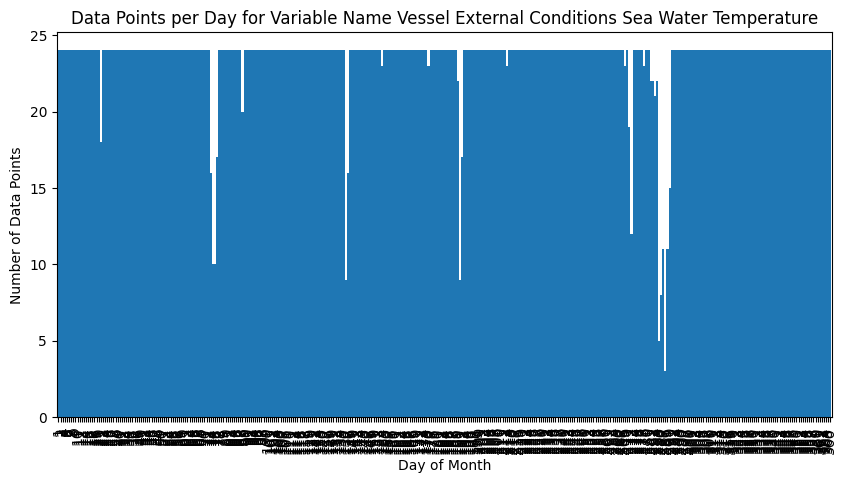

Variable Name: Vessel External Conditions Northward Wind Velocity
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


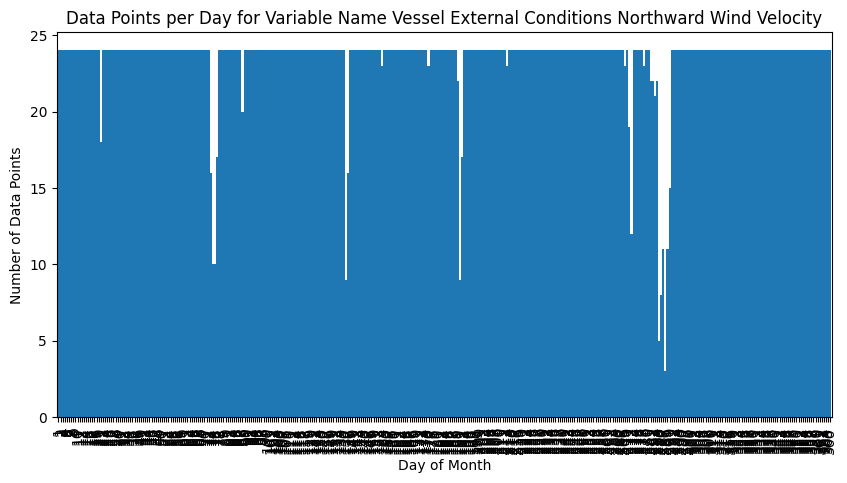

Variable Name: Vessel External Conditions Eastward Wind Velocity
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


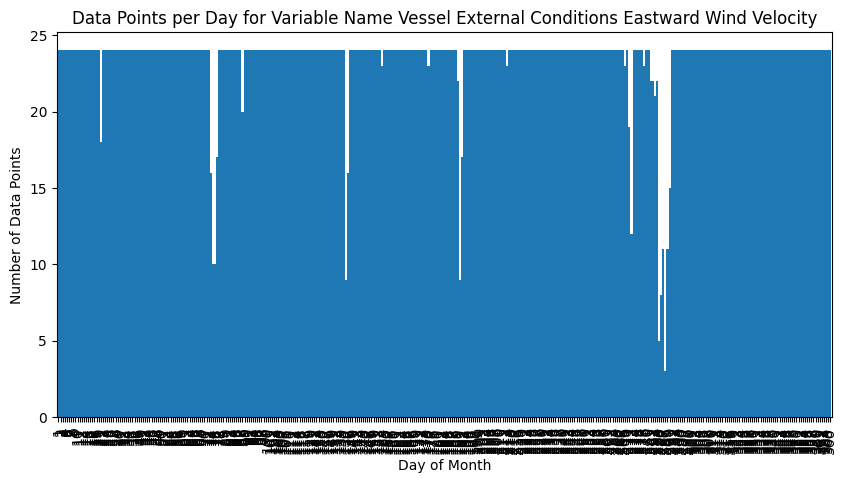

Variable Name: Main Engine Fuel Load %
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


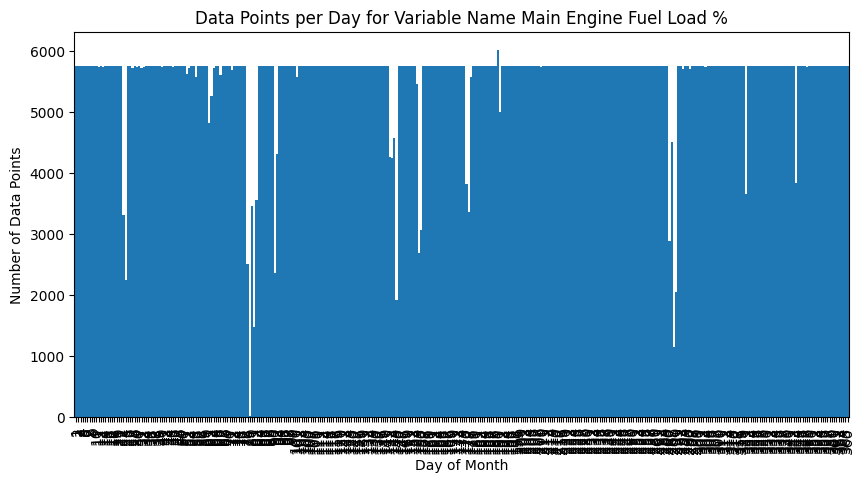

Variable Name: Main Engine Scavenging Air Pressure
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


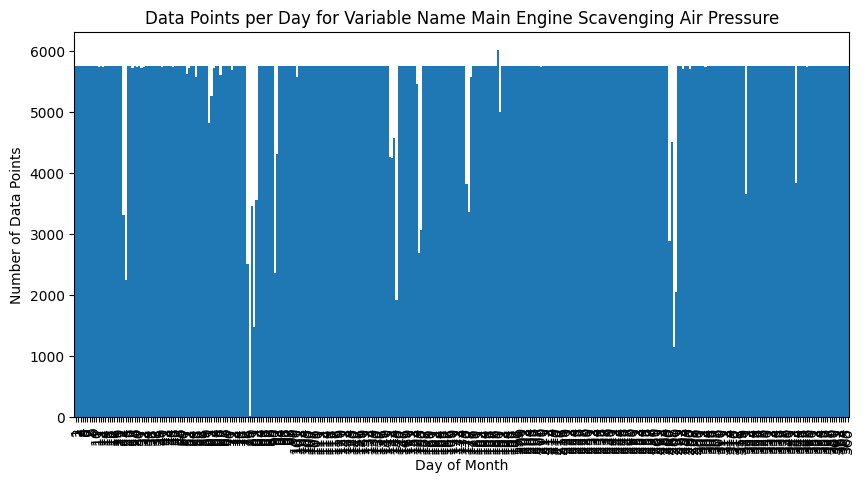

Variable Name: Vessel External Conditions Eastward Sea Water Velocity
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


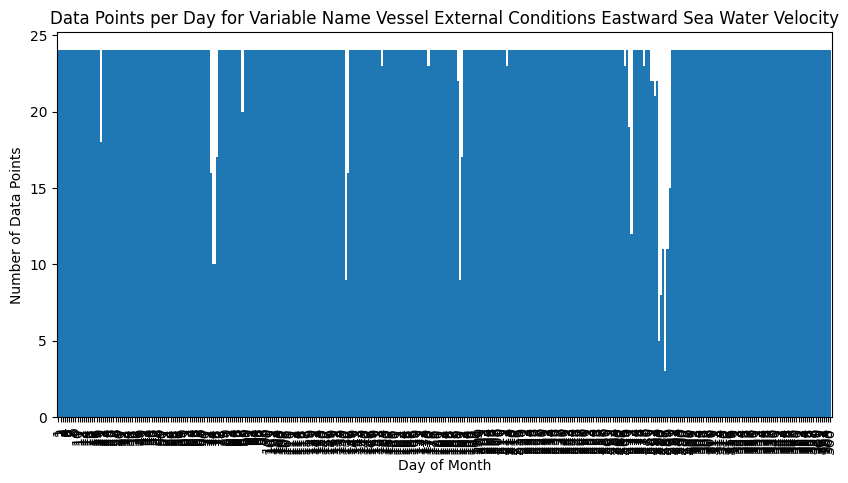

Variable Name: Vessel External Conditions Northward Sea Water Velocity
Expected days: 365
Actual days: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12), np.int32(13), np.int32(14), np.int32(15), np.int32(16), np.int32(17), np.int32(18), np.int32(19), np.int32(20), np.int32(21), np.int32(22), np.int32(23), np.int32(24), np.int32(25), np.int32(26), np.int32(27), np.int32(28), np.int32(29), np.int32(30), np.int32(31)]


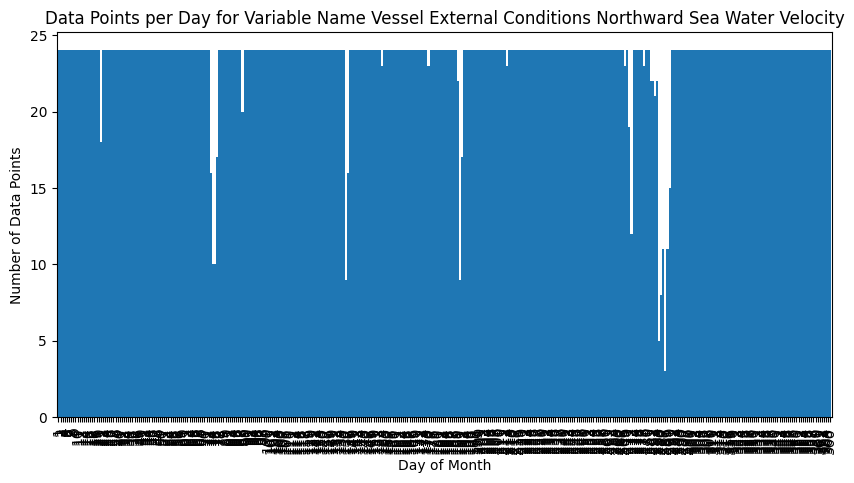

In [28]:
for var_name, var_qid in qid_mapping_dict.items():
    check_monthly_distribution(df, var_qid, var_name)

In [ ]:
# TODO: check hypothesis: what days are missing depends on the provider

In [10]:
def check_monthly_distribution(df, month):
    month_data = df[df['utc_timestamp'].dt.month == month]
    counts = month_data['utc_timestamp'].dt.day.value_counts().sort_index()
    total_data_points = len(month_data)
    
    plt.figure(figsize=(10, 6))
    counts.plot(kind='bar')
    plt.title(f'Distribution of Data Points in {datetime(2023, month, 1).strftime("%B")} (Total: {total_data_points})')
    plt.xlabel('Day of Month')
    plt.ylabel('Number of Data Points')
    plt.show()

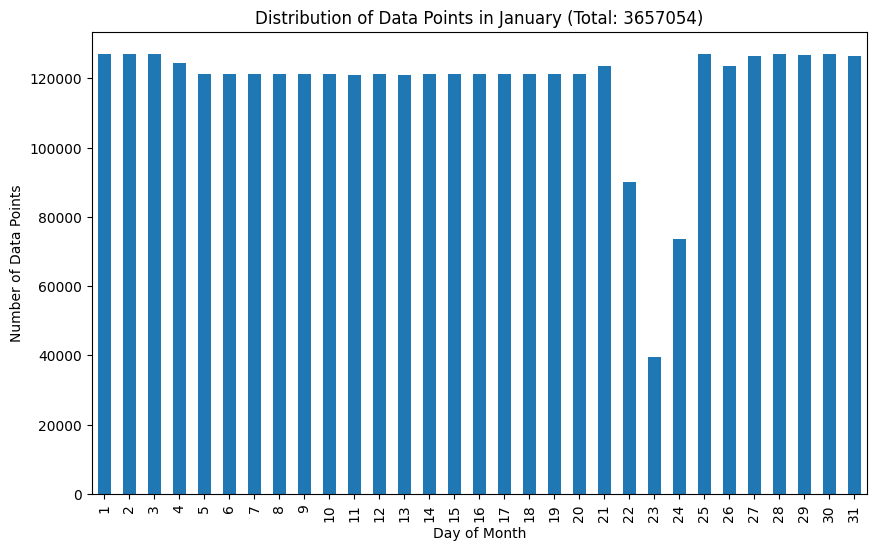

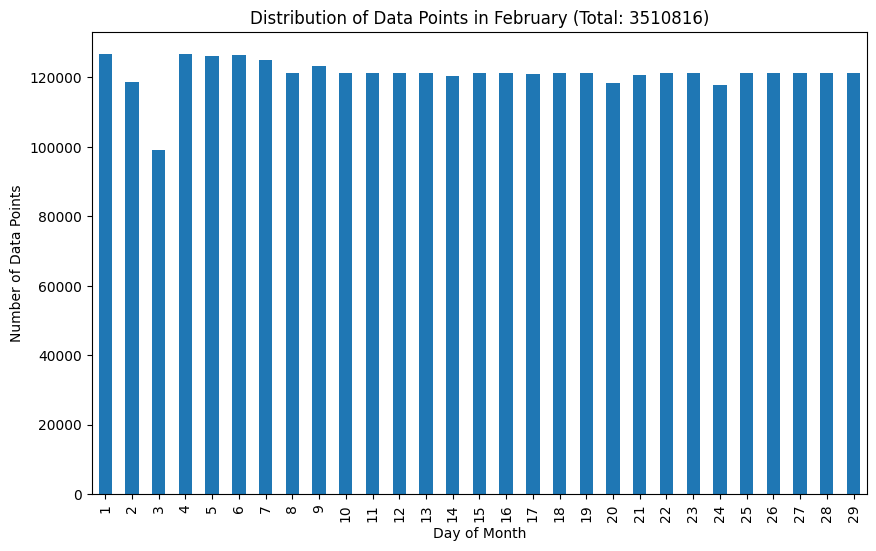

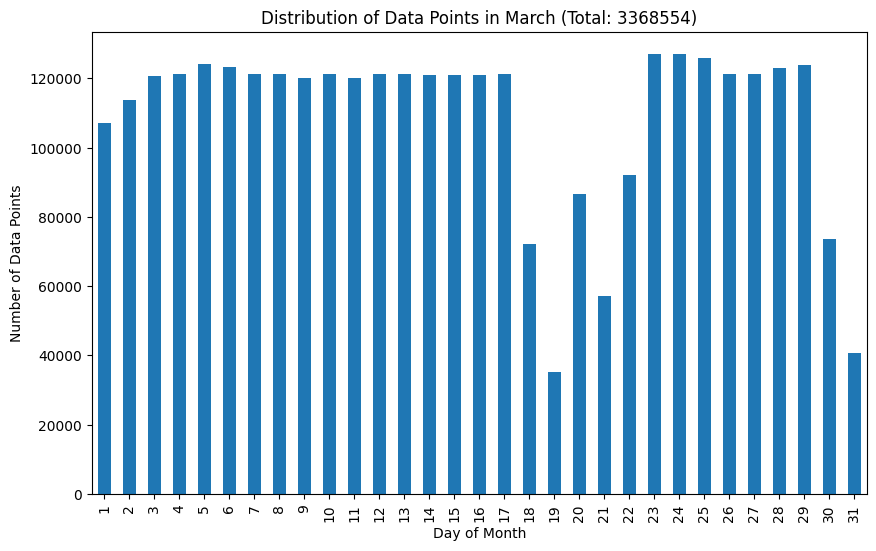

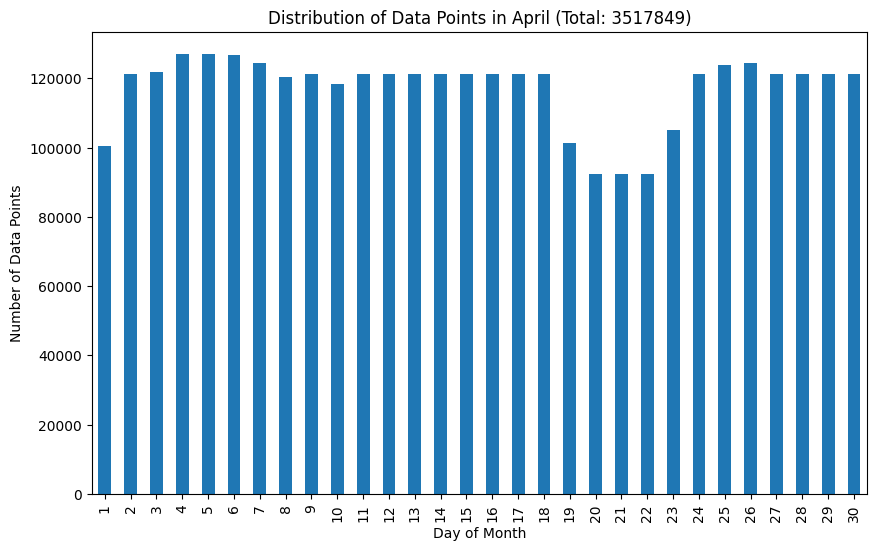

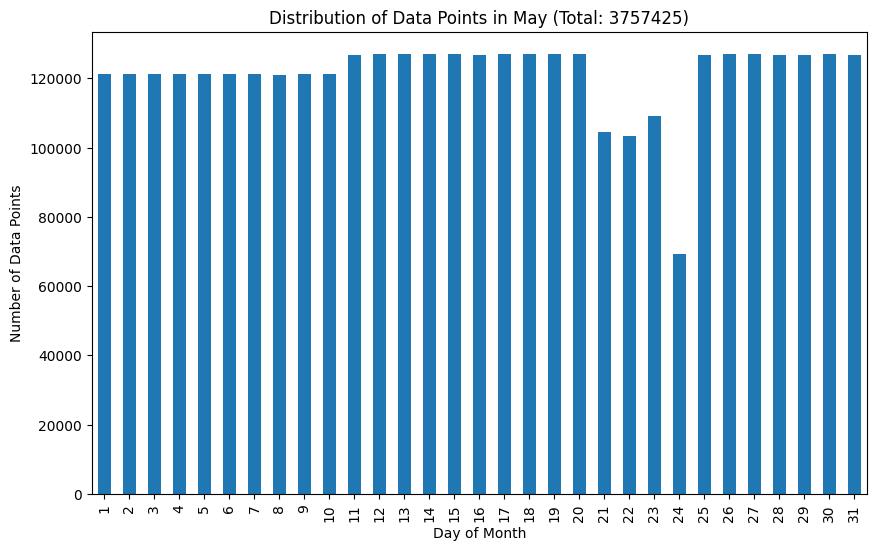

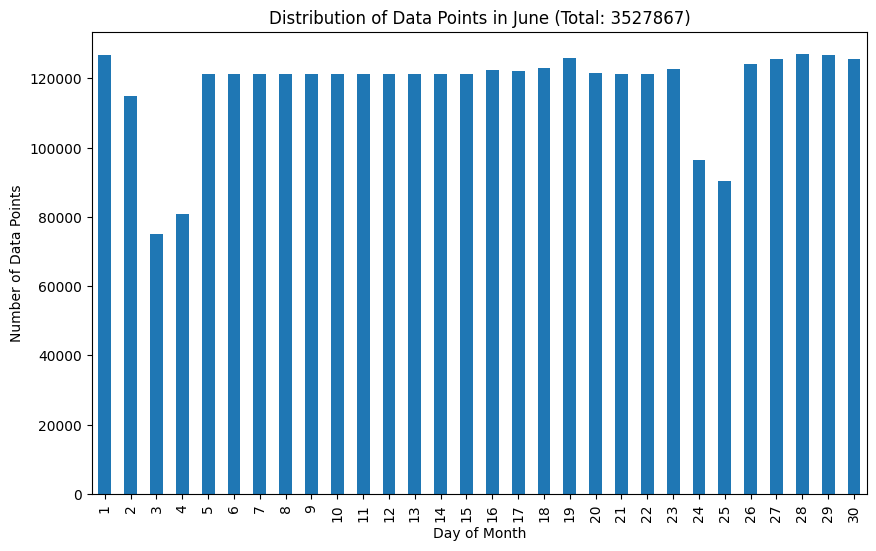

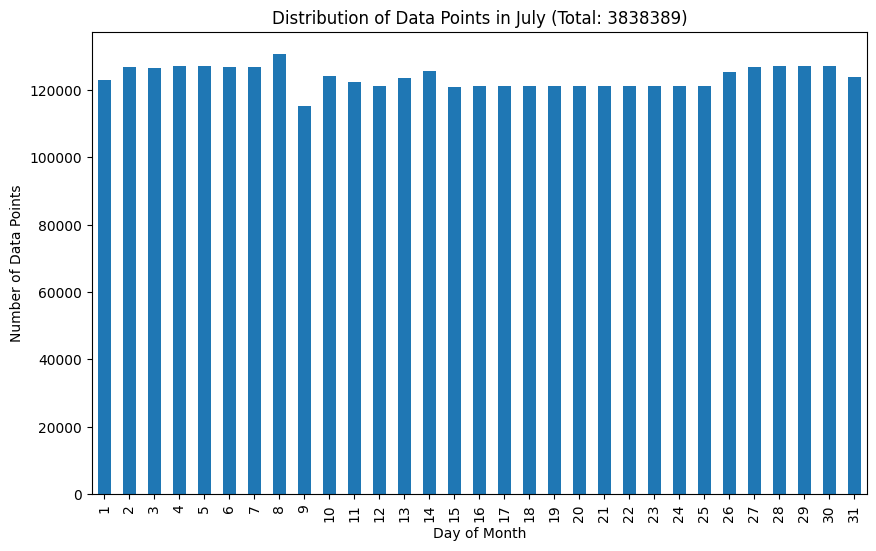

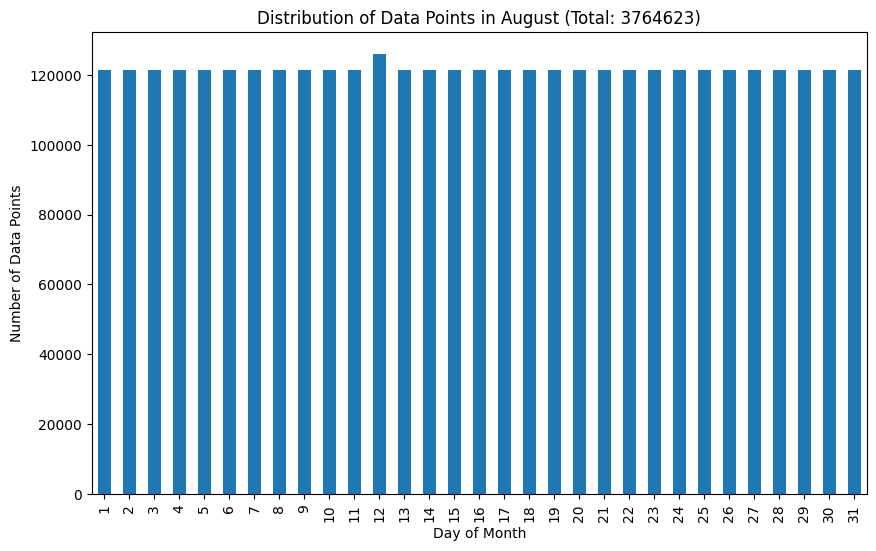

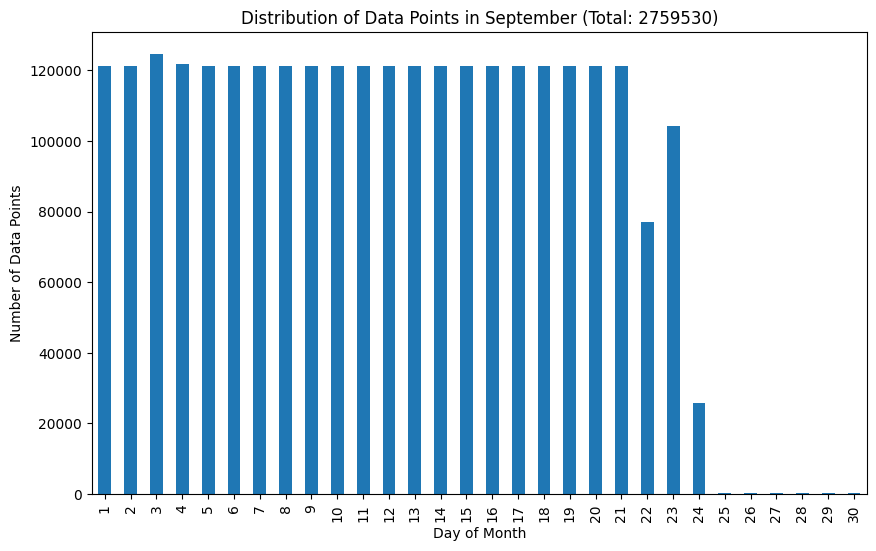

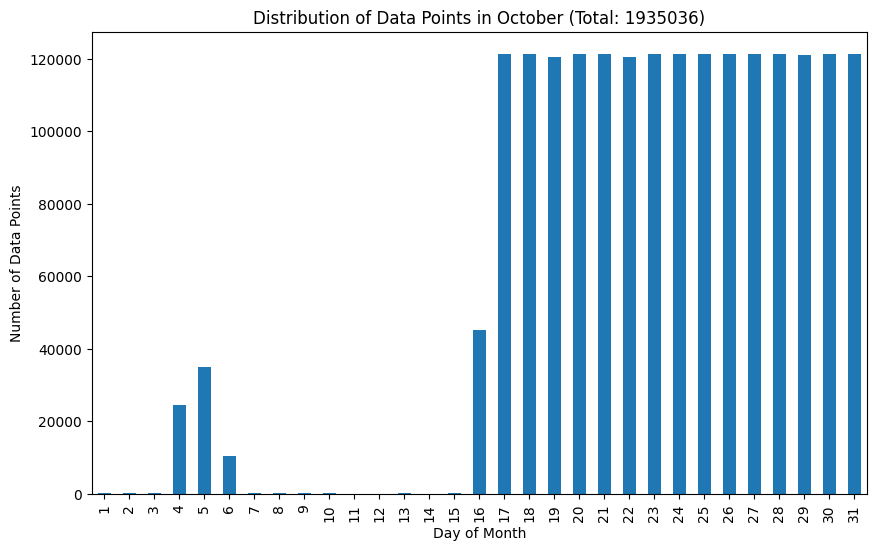

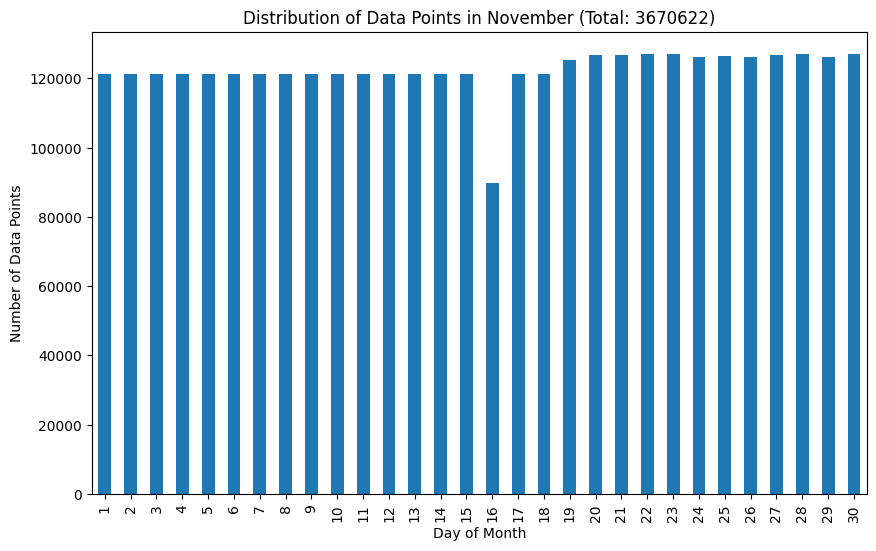

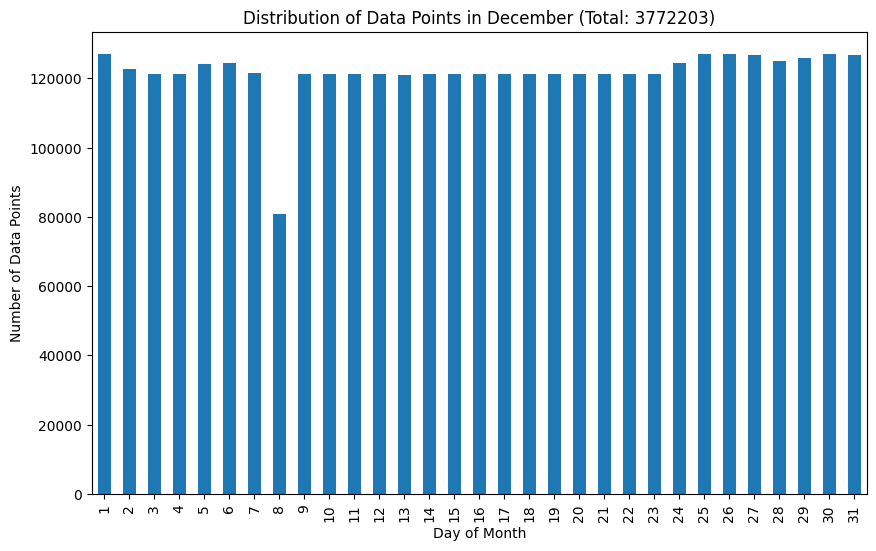

In [11]:
for i in range(1, 13):
    check_monthly_distribution(df, i)